In [1]:
import fastai
import pandas as pd

In [2]:
fastai.__version__

'1.0.60'

In [3]:
import wget
import time
import os
import copy

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [5]:
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [6]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [7]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))

In [8]:
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_224by224',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' '))

In [84]:
# Let's inspect the object
# src.__dir__()

In [12]:
src.train.databunch

<bound method LabelList.databunch of LabelList (24858 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
7;1;2;0,5,1,18,0
Path: /home/ubuntu/datasets/human-protein-atlas>

In [13]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (6214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
7;2,23,23;2,0;21,12
Path: /home/ubuntu/datasets/human-protein-atlas>

^ that looks correct. We have 80% of the images in train databunch as specified.

In [23]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

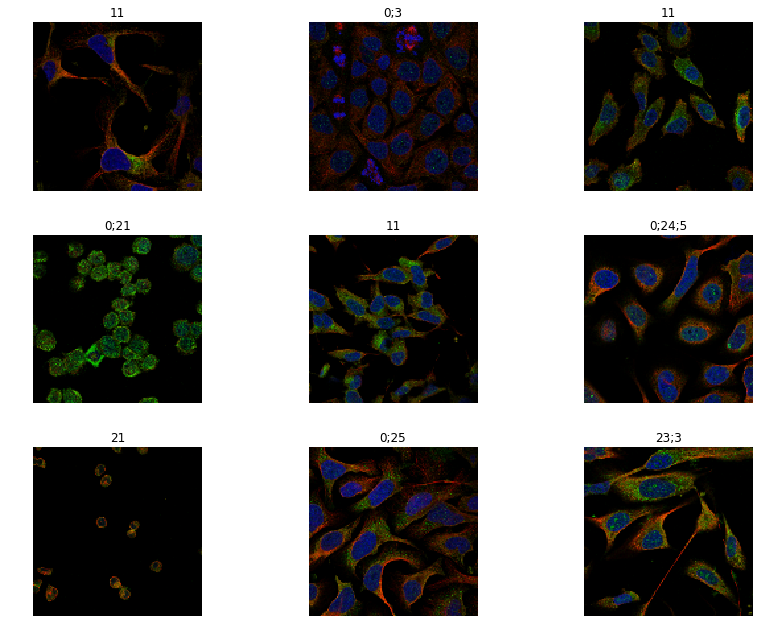

In [24]:
data.show_batch(rows=3, figsize=(12,9))

In [16]:
arch = models.resnet152
acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.2)
f1_score = partial(fbeta, thresh=0.2, beta=1)
# f1_callback = F1_callback()

In [17]:
setattr(src, 'device', 'cuda') 

In [25]:
learn = cnn_learner(data, arch, metrics=[acc_02, f1_score])

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


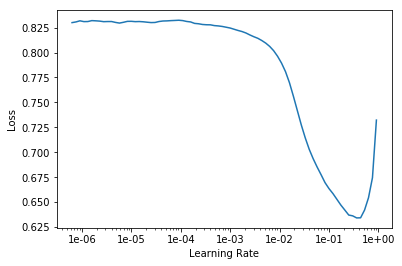

In [27]:
learn.recorder.plot()

In [28]:
lr = 0.01

In [29]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.164170,0.155359,0.928842,0.389434,01:27
1,0.149948,0.147403,0.934457,0.431466,01:29
2,0.145339,0.140879,0.939475,0.460657,01:28
3,0.138942,0.135809,0.937503,0.477891,01:29
4,0.135912,0.134616,0.938330,0.485880,01:29


In [22]:
# for size 62
# learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.172146,0.164291,0.924623,0.352332,00:36
1,0.159438,0.158683,0.932273,0.367234,00:37
2,0.155335,0.153910,0.931985,0.384507,00:37
3,0.152571,0.151191,0.934313,0.400776,00:37
4,0.151080,0.149926,0.933940,0.410561,00:38


In [30]:
learn.save('stage-1-rn152')

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


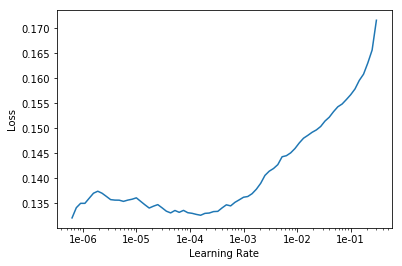

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137983,0.138483,0.936710,0.475345,01:58
1,0.136610,0.135829,0.937078,0.477074,02:00
2,0.131540,0.129021,0.940325,0.515624,02:03
3,0.123066,0.124870,0.941509,0.534970,02:01
4,0.118847,0.123328,0.941567,0.538634,02:00


In [34]:
learn.save('stage-2-rn152')

### Testing the data

In [35]:
test = ImageList.from_folder(os.path.join(data_root,'test_224by224'))
len(test)

11702

In [37]:
learn.data.batch_size

64

In [39]:
preds, _ = learn.get_preds(ds_type=test)

In [40]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [41]:
labelled_preds[:5]

['0 1 7', '0 3 5', '0 1', '19 5', '0 25']

In [47]:
learn.data = (src.add_test_folder('test_224by224'))

In [56]:
fnames = [f.name[:-4] for f in learn.data.test.items]
fnames[:5]

['a504d72c-bacb-11e8-b2b8-ac1f6b6435d0',
 'a4287060-bac7-11e8-b2b7-ac1f6b6435d0',
 '2d9efbe8-bad7-11e8-b2b9-ac1f6b6435d0',
 '2c8ef12a-bad4-11e8-b2b8-ac1f6b6435d0',
 '73fd8e68-bac5-11e8-b2b7-ac1f6b6435d0']

In [57]:
#learn.data.test_ds.__dir__()

In [61]:
len(fnames),len(labelled_preds)

(11702, 24858)

In [58]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

ValueError: arrays must all be same length